# Prediksi Nilai NO2 di Kota Depok, Jawa Barat dengan KNN Regression  

**Tujuan:** Memprediksi nilai NO₂ satu hari ke depan menggunakan KNN Regression, lalu menerapkan threshold untuk klasifikasi status.  

**Data Source:** Sentinel-5P (Copernicus Data Space).  

**Metode:**  
- KNN Regression untuk prediksi nilai kontinu.  
- Threshold Application untuk klasifikasi (Aman/Berbahaya).  

**Periode:** Oktober 2024 - Oktober 2025.  

## DATA UNDERSTANDING  

**Data Understanding** adalah tahap untuk memahami karakteristik dan kualitas data sebelum melakukan analisis.  

**Yang Dilakukan dalam Tahap Ini:**  
- Mengumpulkan Data dari Sentinel-5P (satelit pemantau polusi udara).
- Mengeksplorasi Struktur Data: Melihat jumlah baris, kolom, tipe data.
- Statistik Deskriptif: Mean, std, min, max dari NO₂.
- Visualisasi Time Series: Melihat pola dan trend data NO₂.
- Deteksi Missing Values: Mengidentifikasi data yang hilang.
- Analisis Distribusi: Memahami sebaran nilai NO₂.  

**Output:** Pemahaman tentang data NO₂ di Kota Depok, Jawa Barat periode Oktober 2024 - Oktober 2025.  

### Import Libraries  

In [1]:
import openeo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import os, time, warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, ConfusionMatrixDisplay
)

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Semua library berhasil diimport")

Semua library berhasil diimport


### Pengumpulan Data  

**Tujuan:**  
- Mengumpulkan data time series NO₂ dari satelit.
- Memahami struktur dan format data.
- Menyimpan data mentah untuk analisis lanjutan.

In [2]:
# 1. Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# 2. Area of Interest (AOI) - Kota Depok, Jawa Barat
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [106.73, -6.36],
            [106.73, -6.48],
            [106.88, -6.48],
            [106.88, -6.36],
            [106.73, -6.36],
        ]
    ],
}

# 3. Load data Sentinel-5P
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 106.73,
        "south": -6.48,
        "east": 106.88,
        "north": -6.36,
    },
    temporal_extent=["2024-10-02", "2025-11-01"],
    bands=["NO2"],
)

# 4. Mask nilai negatif
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

# 5. Agregasi temporal (harian)
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6. Agregasi spasial (mean dalam AOI)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# 7. Jalankan batch job
job = daily_mean_aoi.execute_batch(out_format="CSV")
print("\nMenunggu job OpenEO selesai...")

while True:
    status = job.describe()["status"]
    print(f"Status: {status}")
    if status == "finished":
        break
    elif status == "error":
        raise RuntimeError("Job gagal")
    time.sleep(15)

# 8. Unduh hasil
results = job.get_results()
results.download_files("no2_results")

# 9. Baca file CSV
csv_files = [f for f in os.listdir("no2_results") if f.endswith(".csv")]
df = pd.read_csv(os.path.join("no2_results", csv_files[0]))

# 10. Data preprocessing
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
df.to_csv("timeseries.csv", index=False)

print(f"\nData berhasil dikumpulkan")
print(f"  - Total records: {len(df)}")
print(f"  - Periode: {df['date'].min()} hingga {df['date'].max()}")
print(f"  - File: timeseries.csv")
print(f"\nData pertama (5 baris):")
print(df.head())

Authenticated using refresh token.


0:00:00 Job 'j-2512101446164f648b6cb45661a54f0b': send 'start'


0:00:14 Job 'j-2512101446164f648b6cb45661a54f0b': created (progress 0%)


0:00:19 Job 'j-2512101446164f648b6cb45661a54f0b': created (progress 0%)


## DATA PREPARATION  

**Data Preparation** adalah tahap mempersiapkan data mentah menjadi format yang siap untuk modeling.  

Tahap persiapan data untuk machine learning:
- Missing Values: Interpolasi linear.
- Supervised Learning: Membuat lag features.
- Train-Test Split: 80-20 split.
- Normalisasi: MinMaxScaler untuk KNN.  

### Preprocessing - Interpolasi Missing Values  
**Tujuan:** Menangani missing values dengan interpolasi linier.


Missing values SEBELUM: 267 (67.42%)
Missing values SESUDAH: 0

Statistik NO2 setelah interpolasi:
count    396.000000
mean       0.000065
std        0.000030
min        0.000017
25%        0.000044
50%        0.000063
75%        0.000083
max        0.000290
Name: NO2, dtype: float64


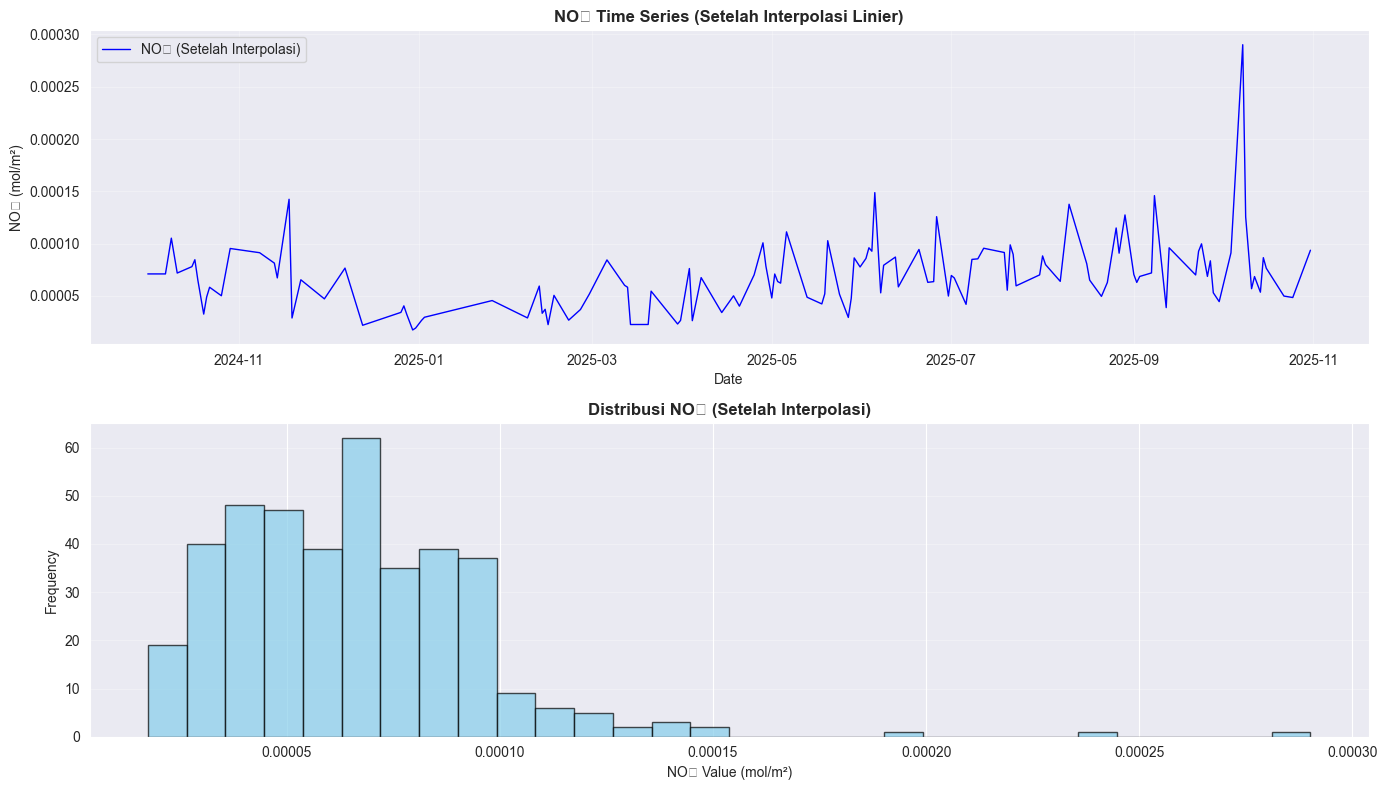

In [3]:
# Baca data
df = pd.read_csv("timeseries.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

# Cek missing values SEBELUM
missing_before = df["NO2"].isna().sum()
print(f"\nMissing values SEBELUM: {missing_before} ({missing_before/len(df)*100:.2f}%)")

# Interpolasi linier
df["NO2"] = df["NO2"].interpolate(method="linear")
df["NO2"] = df["NO2"].fillna(method="bfill").fillna(method="ffill")

# Cek missing values SESUDAH
missing_after = df["NO2"].isna().sum()
print(f"Missing values SESUDAH: {missing_after}")

# Statistik
print(f"\nStatistik NO2 setelah interpolasi:")
print(df["NO2"].describe())

# Visualisasi
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(df["date"], df["NO2"], color="blue", linewidth=1, label="NO₂ (Setelah Interpolasi)")
axes[0].set_title("NO₂ Time Series (Setelah Interpolasi Linier)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("NO₂ (mol/m²)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].hist(df["NO2"], bins=30, edgecolor="black", alpha=0.7, color="skyblue")
axes[1].set_title("Distribusi NO₂ (Setelah Interpolasi)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("NO₂ Value (mol/m²)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

### Deteksi Dan Penanganan Outlier Menggunakan LOF


DETEKSI DAN PENANGANAN OUTLIER MENGGUNAKAN LOF

Total outlier terdeteksi: 23 dari 396 data

Outlier berhasil diperhalus menggunakan rolling median smoothing.


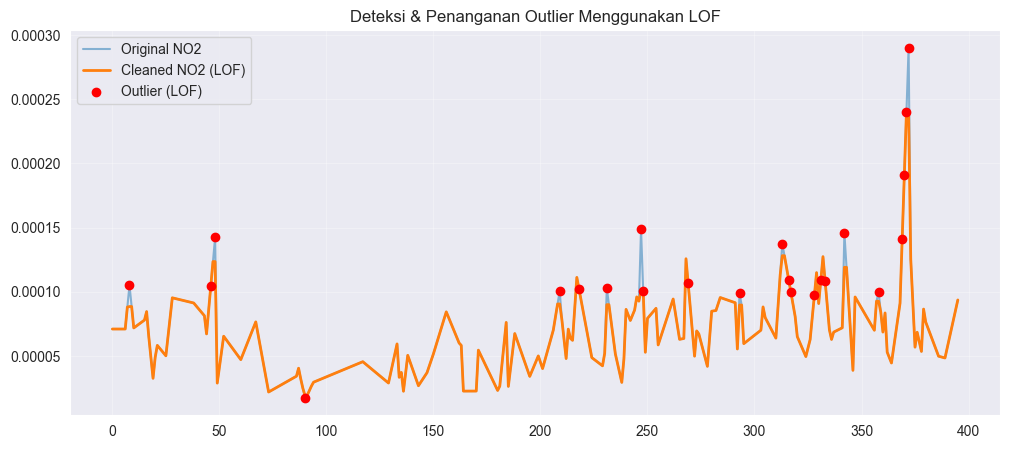

In [4]:
print("\n" + "="*80)
print("DETEKSI DAN PENANGANAN OUTLIER MENGGUNAKAN LOF")
print("="*80)

# Ambil hanya kolom NO2
no2_values = df["NO2"].values.reshape(-1, 1)

# LOF untuk deteksi outlier
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination="auto",
    novelty=False
)

y_pred_outlier = lof.fit_predict(no2_values)

# -1 = outlier, 1 = normal
df["is_outlier"] = (y_pred_outlier == -1).astype(int)

print(f"\nTotal outlier terdeteksi: {df['is_outlier'].sum()} dari {len(df)} data")

# Tangani outlier → replace dengan rolling median (window=3)
df["NO2_cleaned"] = df["NO2"].copy()

mask_out = df["is_outlier"] == 1

df.loc[mask_out, "NO2_cleaned"] = (
    df["NO2"].rolling(window=3, center=True).median()
)

# Jika rolling median menghasilkan NaN (di awal/akhir), fallback ke nilai asli
df["NO2_cleaned"].fillna(df["NO2"], inplace=True)

print("\nOutlier berhasil diperhalus menggunakan rolling median smoothing.")

# Visualisasi
plt.figure(figsize=(12, 5))

plt.plot(df["NO2"], label="Original NO2", alpha=0.5)
plt.plot(df["NO2_cleaned"], label="Cleaned NO2 (LOF)", linewidth=2)

# Tandai outlier
plt.scatter(df.index[mask_out], df.loc[mask_out, "NO2"],
            color="red", label="Outlier (LOF)", zorder=5)

plt.title("Deteksi & Penanganan Outlier Menggunakan LOF")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Gunakan data yang sudah dibersihkan untuk supervised
df["NO2"] = df["NO2_cleaned"]

# Buang kolom intermediate
df.drop(columns=["NO2_cleaned", "is_outlier"], inplace=True)


### Transformasi ke Supervised Learning  

**Tujuan:** Konversi time series menjadi supervised dataset dengan lagged features.  

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
    """
    Konversi time series menjadi supervised learning dataset.
    """
    df_data = pd.DataFrame(data)
    cols, names = [], []

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_data.shift(i))
        names += [f"NO2(t-{i})"]

    # Output sequence (t)
    for i in range(0, n_out):
        cols.append(df_data.shift(-i))
        if i == 0:
            names += ["NO2(t)"]
        else:
            names += [f"NO2(t+{i})"]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropna:
        agg.dropna(inplace=True)

    return agg

# Gunakan 2 lag
n_lags = 2
supervised_df = series_to_supervised(df[["NO2"]], n_in=n_lags, n_out=1)

print(f"\nTransformasi supervised learning dengan lag: {n_lags}")
print(f"  - Total samples: {supervised_df.shape}")
print(f"  - Input Features: {list(supervised_df.columns[:-1])}")
print(f"  - Target: {supervised_df.columns[-1]}")
print(f"\nData pertama (5 baris):")
print(supervised_df.head())


Transformasi supervised learning dengan lag: 2
  - Total samples: (394, 3)
  - Input Features: ['NO2(t-2)', 'NO2(t-1)']
  - Target: NO2(t)

Data pertama (5 baris):
   NO2(t-2)  NO2(t-1)    NO2(t)
2  0.000071  0.000071  0.000071
3  0.000071  0.000071  0.000071
4  0.000071  0.000071  0.000071
5  0.000071  0.000071  0.000071
6  0.000071  0.000071  0.000071


### Train-Test Split  

Split data 80-20 untuk training dan testing (shuffle=False untuk time series).  

Data split: Train (316, 2) | Test (78, 2)
Target range: [0.00001922, 0.00024040]


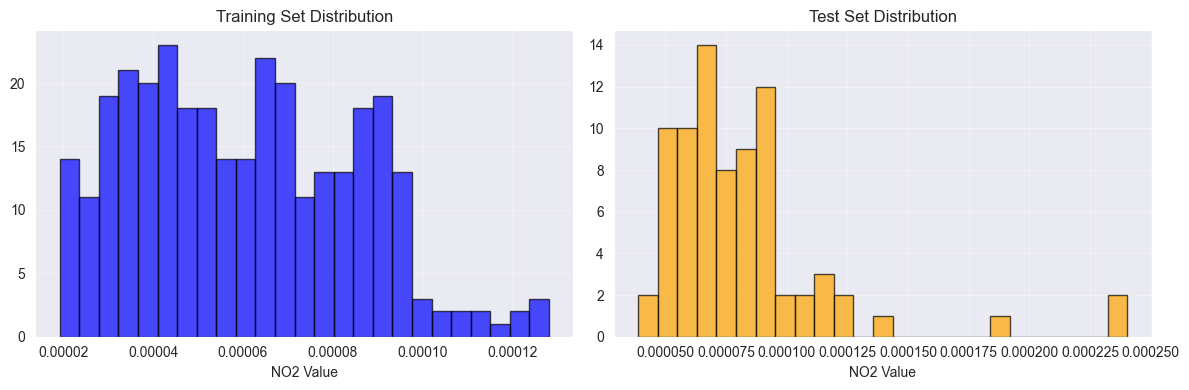

In [6]:
# Prepare features dan target
X = supervised_df[["NO2(t-2)", "NO2(t-1)"]].values
y = supervised_df["NO2(t)"].values

# Train-test split (manual time series split)
test_size = int(len(X) * 0.2)

X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

print(f"Data split: Train {X_train.shape} | Test {X_test.shape}")
print(f"Target range: [{y.min():.8f}, {y.max():.8f}]")

# Visualisasi distribusi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(y_train, bins=25, alpha=0.7, color="blue", edgecolor="black")
ax1.set_title("Training Set Distribution")
ax1.set_xlabel("NO2 Value")
ax1.grid(True, alpha=0.3)

ax2.hist(y_test, bins=25, alpha=0.7, color="orange", edgecolor="black")
ax2.set_title("Test Set Distribution")  
ax2.set_xlabel("NO2 Value")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Normalisasi Data  

MinMaxScaler untuk normalisasi fitur ke rentang [0,1]. Fit pada training set saja, simpan scaler untuk deployment.

Normalisasi completed:
- Training scaled: (316, 2) | Range: [0, 1]
- Test scaled: (78, 2)
- Scaler saved: minmax_scaler.pkl


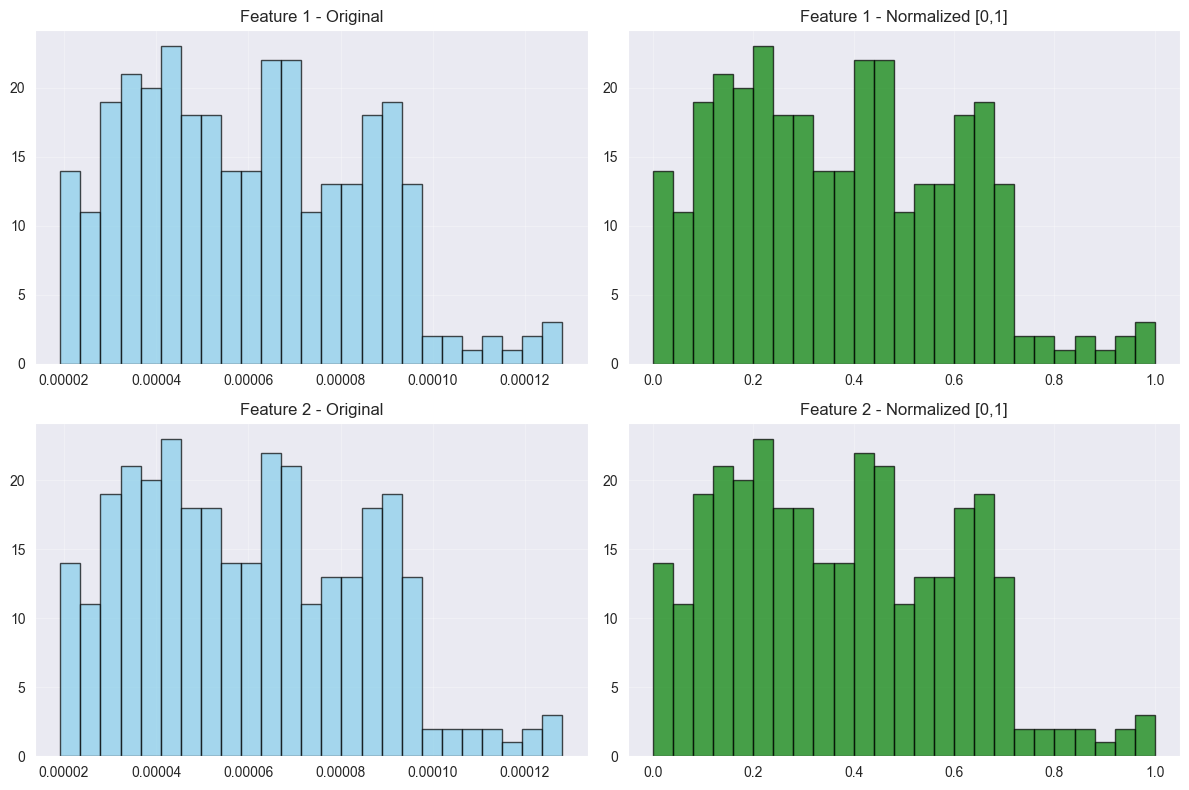

In [7]:
# MinMaxScaler normalisasi
scaler = MinMaxScaler()
scaler.fit(X_train)  # Fit hanya pada training set

# Transform training dan test set
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan scaler untuk deployment
joblib.dump(scaler, 'minmax_scaler.pkl')

print(f"Normalisasi completed:")
print(f"- Training scaled: {X_train_scaled.shape} | Range: [0, 1]")
print(f"- Test scaled: {X_test_scaled.shape}")
print(f"- Scaler saved: minmax_scaler.pkl")

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Before normalization
axes[0, 0].hist(X_train[:, 0], bins=25, alpha=0.7, color="skyblue", edgecolor="black")
axes[0, 0].set_title("Feature 1 - Original")
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(X_train_scaled[:, 0], bins=25, alpha=0.7, color="green", edgecolor="black")
axes[0, 1].set_title("Feature 1 - Normalized [0,1]")
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(X_train[:, 1], bins=25, alpha=0.7, color="skyblue", edgecolor="black")
axes[1, 0].set_title("Feature 2 - Original")
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(X_train_scaled[:, 1], bins=25, alpha=0.7, color="green", edgecolor="black")
axes[1, 1].set_title("Feature 2 - Normalized [0,1]")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Definisikan Batas Ambang (Threshold) dan Buat Labels  

**Tujuan:** Tentukan threshold untuk klasifikasi binary (Aman/Berbahaya).  

**Catatan:** Labels ini akan digunakan untuk evaluasi setelah prediksi regression.


Threshold Definition:
  - Menggunakan: 75th percentile
  - Nilai threshold: 0.00008347 mol/m²

  - Label 0 (AMAN):      NO2 ≤ 0.00008347
  - Label 1 (BERBAHAYA): NO2 > 0.00008347

Distribusi Label (untuk evaluasi threshold):
  - Label 0 (AMAN):      295 samples (74.9%)
  - Label 1 (BERBAHAYA): 99 samples (25.1%)


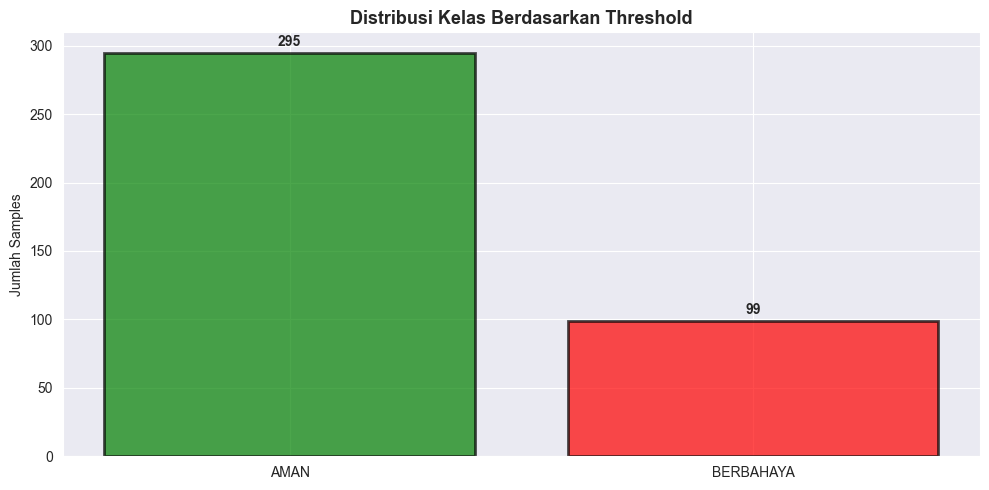

CATATAN: Model akan memprediksi nilai NO2 (regression), lalu threshold diterapkan


In [8]:
# Gunakan 75th percentile sebagai threshold
threshold = supervised_df["NO2(t)"].quantile(0.75)

print(f"\nThreshold Definition:")
print(f"  - Menggunakan: 75th percentile")
print(f"  - Nilai threshold: {threshold:.8f} mol/m²")
print(f"\n  - Label 0 (AMAN):      NO2 ≤ {threshold:.8f}")
print(f"  - Label 1 (BERBAHAYA): NO2 > {threshold:.8f}")

# Buat binary labels untuk evaluasi nanti (setelah regression)
binary_labels = (supervised_df["NO2(t)"] > threshold).astype(int)

# Statistik label
print(f"\nDistribusi Label (untuk evaluasi threshold):")
label_counts = binary_labels.value_counts().sort_index()
print(f"  - Label 0 (AMAN):      {label_counts[0]} samples ({label_counts[0]/len(binary_labels)*100:.1f}%)")
print(f"  - Label 1 (BERBAHAYA): {label_counts[1]} samples ({label_counts[1]/len(binary_labels)*100:.1f}%)")

# Visualisasi class distribution
fig, ax = plt.subplots(figsize=(10, 5))
labels_text = ['AMAN', 'BERBAHAYA']
colors_bar = ['green', 'red']
ax.bar(labels_text, label_counts.values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_title('Distribusi Kelas Berdasarkan Threshold', fontsize=13, fontweight='bold')
ax.set_ylabel('Jumlah Samples')
for i, v in enumerate(label_counts.values):
    ax.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"CATATAN: Model akan memprediksi nilai NO2 (regression), lalu threshold diterapkan")

## MODELLING  

**Modelling** adalah tahap membangun, melatih, dan mengevaluasi model machine learning.  

**Yang Dilakukan dalam Tahap Ini:**  
1. Training: Eksperimen nilai K, pilih yang terbaik.  

2. Evaluasi: Metrik regression dan analisis WHO standards.  

3. Deployment: Prediksi data baru. 

### KNN Regression Modeling  

**Tujuan:** Training model KNN Regression untuk memprediksi nilai NO₂ kontinyu dengan berbagai nilai K.  


----------------------------------------------------------------------
Variasi Nilai K untuk KNN Regression
----------------------------------------------------------------------
k= 2 | MSE=8.90544659e-10 | RMSE=0.00002984 | MAE=0.00001641 | MAPE=17.0617% | R²=0.2914
k= 3 | MSE=8.90351457e-10 | RMSE=0.00002984 | MAE=0.00001578 | MAPE=16.2763% | R²=0.2916
k= 5 | MSE=7.91442603e-10 | RMSE=0.00002813 | MAE=0.00001455 | MAPE=14.8127% | R²=0.3703
k= 7 | MSE=8.32480004e-10 | RMSE=0.00002885 | MAE=0.00001475 | MAPE=15.0139% | R²=0.3376
k= 9 | MSE=8.38431796e-10 | RMSE=0.00002896 | MAE=0.00001505 | MAPE=15.4940% | R²=0.3329
k=11 | MSE=8.83902630e-10 | RMSE=0.00002973 | MAE=0.00001545 | MAPE=15.8310% | R²=0.2967

Best K: 5 (RMSE=0.00002813)


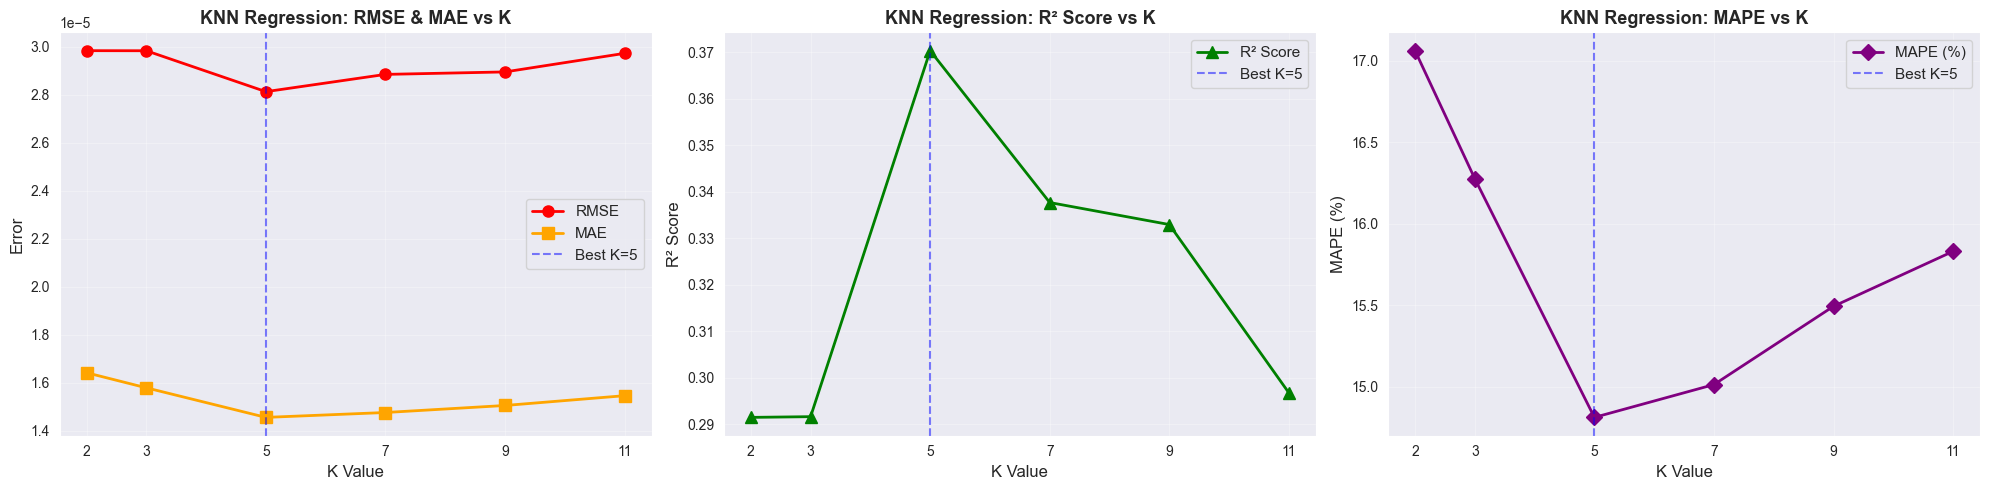


Tabel Ringkasan Hasil Eksperimen KNN Regression:


,k,mse,rmse,mae,r2,mape
0,2,8.90544659e-10,0.00002984,0.00001641,0.2914,17.0617
1,3,8.90351457e-10,0.00002984,0.00001578,0.2916,16.2763
2,5,7.91442603e-10,0.00002813,0.00001455,0.3703,14.8127
3,7,8.32480004e-10,0.00002885,0.00001475,0.3376,15.0139
4,9,8.38431796e-10,0.00002896,0.00001505,0.3329,15.4940
5,11,8.83902630e-10,0.00002973,0.00001545,0.2967,15.8310


In [9]:
# Modeling dengan KNN Regression (eksperimen beberapa K)
k_values = [2, 3, 5, 7, 9, 11]
print(f"\n" + "-"*70)
print(f"Variasi Nilai K untuk KNN Regression")
print("-"*70)

results_k = []
for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Hitung metrik regression
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # dalam persen
    
    results_k.append({
        'k': k,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    })
    
    print(f"k={k:2d} | MSE={mse:.8e} | RMSE={rmse:.8f} | MAE={mae:.8f} | MAPE={mape:.4f}% | R²={r2:.4f}")

results_k_df = pd.DataFrame(results_k)
best_k_idx = results_k_df['rmse'].idxmin()
best_k = results_k_df.loc[best_k_idx, 'k']
best_rmse = results_k_df.loc[best_k_idx, 'rmse']

print(f"\nBest K: {int(best_k)} (RMSE={best_rmse:.8f})")

# Visualisasi performa model
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot RMSE dan MAE
axes[0].plot(results_k_df['k'], results_k_df['rmse'], marker='o', linewidth=2, markersize=8, label='RMSE', color='red')
axes[0].plot(results_k_df['k'], results_k_df['mae'], marker='s', linewidth=2, markersize=8, label='MAE', color='orange')
axes[0].axvline(x=best_k, color='blue', linestyle='--', alpha=0.5, label=f'Best K={int(best_k)}')
axes[0].set_xlabel('K Value', fontsize=12)
axes[0].set_ylabel('Error', fontsize=12)
axes[0].set_title('KNN Regression: RMSE & MAE vs K', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_values)

# Plot R²
axes[1].plot(results_k_df['k'], results_k_df['r2'], marker='^', linewidth=2, markersize=8, label='R² Score', color='green')
axes[1].axvline(x=best_k, color='blue', linestyle='--', alpha=0.5, label=f'Best K={int(best_k)}')
axes[1].set_xlabel('K Value', fontsize=12)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('KNN Regression: R² Score vs K', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_values)

# Plot MAPE
axes[2].plot(results_k_df['k'], results_k_df['mape'], marker='D', linewidth=2, markersize=8, label='MAPE (%)', color='purple')
axes[2].axvline(x=best_k, color='blue', linestyle='--', alpha=0.5, label=f'Best K={int(best_k)}')
axes[2].set_xlabel('K Value', fontsize=12)
axes[2].set_ylabel('MAPE (%)', fontsize=12)
axes[2].set_title('KNN Regression: MAPE vs K', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_values)

plt.tight_layout()
plt.show()

# Tabel Hasil Akhir
print("\nTabel Ringkasan Hasil Eksperimen KNN Regression:")
display(results_k_df.style.background_gradient(cmap='coolwarm').format({
    'mse': '{:.8e}',
    'rmse': '{:.8f}',
    'mae': '{:.8f}',
    'mape': '{:.4f}',
    'r2': '{:.4f}'
}))


### Evaluasi Regression & Threshold Application  

**Tujuan:** Evaluasi hasil prediksi regression dan terapkan threshold untuk klasifikasi.  

**Proses:**
- Training final model dengan K terbaik.
- Prediksi nilai NO₂ pada test set (regression).
- Evaluasi Regression: RMSE, MAE, R².
- Terapkan threshold pada prediksi untuk klasifikasi.
- Evaluasi Classification: Accuracy, Precision, Recall, F1.
- Visualisasi: Actual vs Predicted, Residual Plot, Confusion Matrix.


 Model berhasil disimpan sebagai: knn_model.pkl

[A] REGRESSION METRICS (K=5):
  - MSE:   0.0000000008
  - RMSE:  0.0000281326
  - MAE:   0.0000145496
  - MAPE:  14.8127%
  - R²:    0.3703

[B] CLASSIFICATION METRICS (Setelah Threshold):
  - Threshold: 0.00008347 mol/m²
  - Accuracy:  0.7821
  - Precision: 0.7600
  - Recall:    0.6333
  - F1-Score:  0.6909

Confusion Matrix:
  - True Negatives (AMAN → AMAN):          42
  - False Positives (AMAN → BERBAHAYA):    6
  - False Negatives (BERBAHAYA → AMAN):    11
  - True Positives (BERBAHAYA → BERBAHAYA): 19


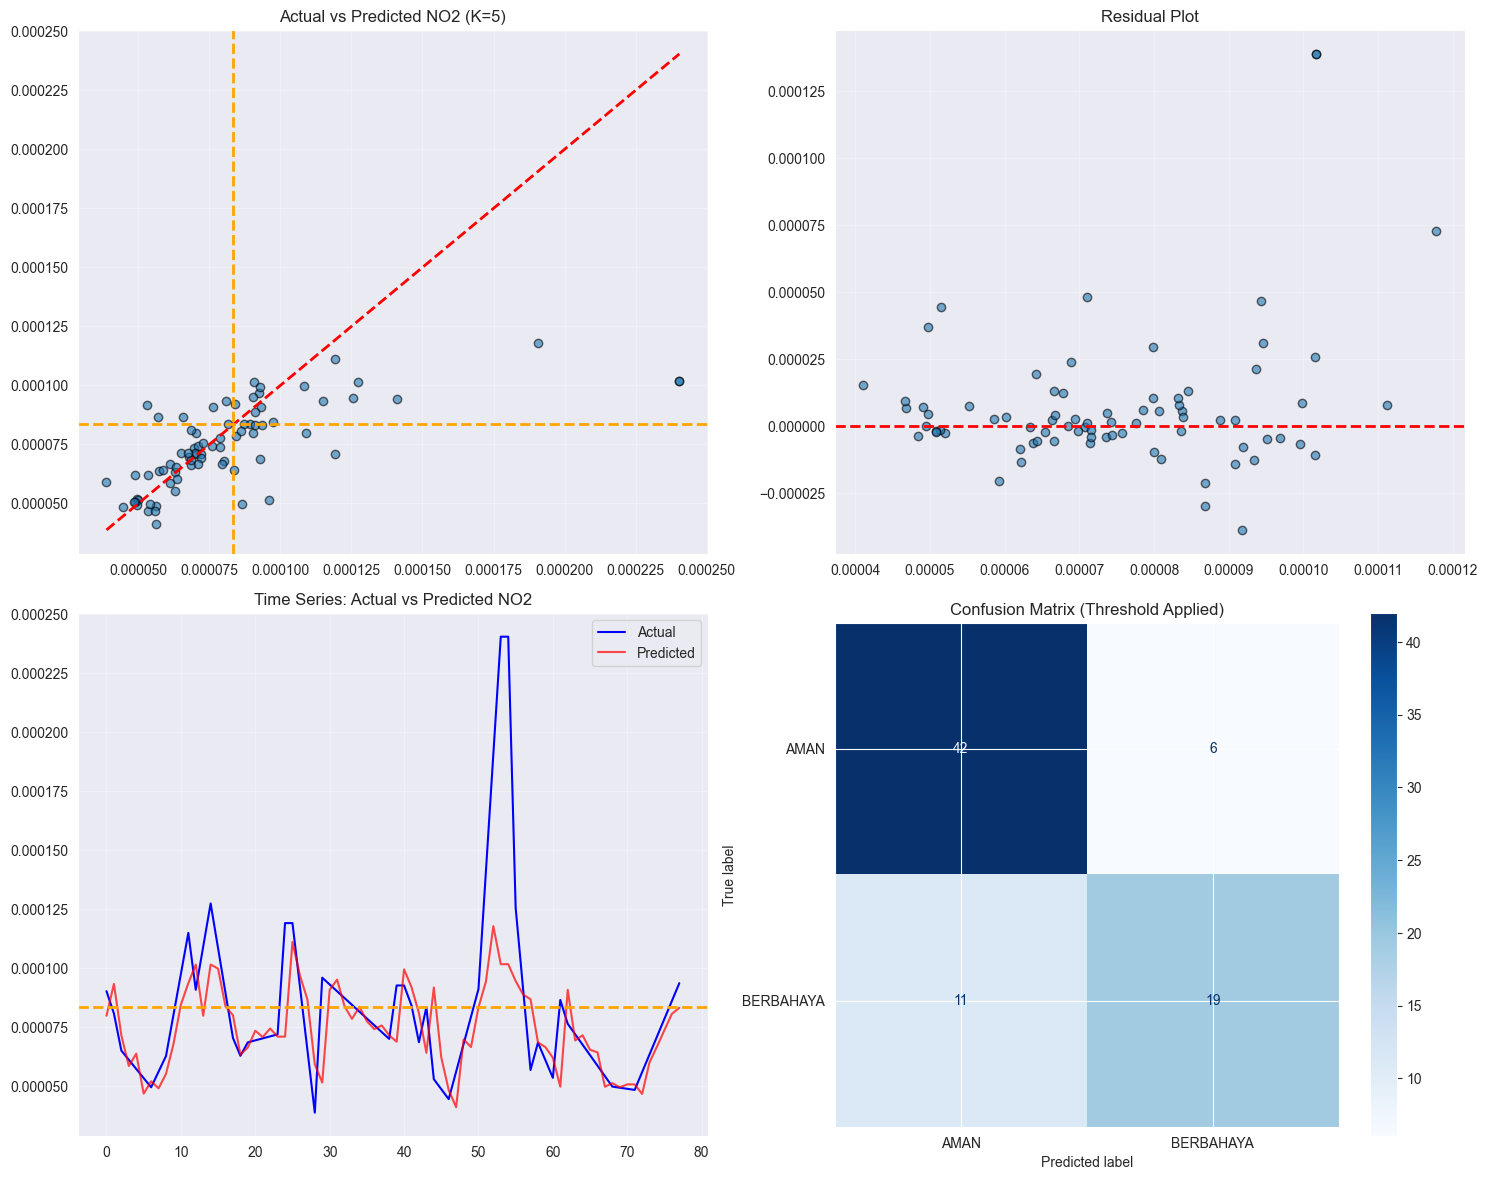


Classification Report:
              precision    recall  f1-score   support

        AMAN       0.79      0.88      0.83        48
   BERBAHAYA       0.76      0.63      0.69        30

    accuracy                           0.78        78
   macro avg       0.78      0.75      0.76        78
weighted avg       0.78      0.78      0.78        78



In [10]:
# Train final model dengan best K (gunakan data yang sudah dinormalisasi)
best_k = int(best_k)
final_model = KNeighborsRegressor(n_neighbors=best_k, metric='euclidean')
final_model.fit(X_train_scaled, y_train)

# SIMPAN MODEL untuk deployment
joblib.dump(final_model, 'knn_model.pkl')
print("\n Model berhasil disimpan sebagai: knn_model.pkl")

# Prediksi nilai NO2 (continuous)
y_pred_regression = final_model.predict(X_test_scaled)

# Hitung metrics regression
mse = mean_squared_error(y_test, y_pred_regression)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_regression)
r2 = r2_score(y_test, y_pred_regression)
mape = np.mean(np.abs((y_test - y_pred_regression) / y_test)) * 100

print(f"\n[A] REGRESSION METRICS (K={best_k}):")
print(f"  - MSE:   {mse:.10f}")
print(f"  - RMSE:  {rmse:.10f}")
print(f"  - MAE:   {mae:.10f}")
print(f"  - MAPE:  {mape:.4f}%")
print(f"  - R²:    {r2:.4f}")

# Terapkan threshold pada prediksi
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred_regression > threshold).astype(int)

# Hitung metrics classification
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
f1 = f1_score(y_test_binary, y_pred_binary, zero_division=0)

print(f"\n[B] CLASSIFICATION METRICS (Setelah Threshold):")
print(f"  - Threshold: {threshold:.8f} mol/m²")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall:    {recall:.4f}")
print(f"  - F1-Score:  {f1:.4f}")

cm = confusion_matrix(y_test_binary, y_pred_binary)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  - True Negatives (AMAN → AMAN):          {tn}")
print(f"  - False Positives (AMAN → BERBAHAYA):    {fp}")
print(f"  - False Negatives (BERBAHAYA → AMAN):    {fn}")
print(f"  - True Positives (BERBAHAYA → BERBAHAYA): {tp}")


fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1 - Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred_regression, alpha=0.6, edgecolors='k')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].axhline(y=threshold, color='orange', linestyle='--', linewidth=2)
axes[0, 0].axvline(x=threshold, color='orange', linestyle='--', linewidth=2)
axes[0, 0].set_title(f'Actual vs Predicted NO2 (K={best_k})')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2 - Residual
residuals = y_test - y_pred_regression
axes[0, 1].scatter(y_pred_regression, residuals, alpha=0.6, edgecolors='k')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3 - Time Series
test_indices = range(len(y_test))
axes[1, 0].plot(test_indices, y_test, label='Actual', color='blue')
axes[1, 0].plot(test_indices, y_pred_regression, label='Predicted', color='red', alpha=0.7)
axes[1, 0].axhline(y=threshold, color='orange', linestyle='--', linewidth=2)
axes[1, 0].set_title('Time Series: Actual vs Predicted NO2')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4 - Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AMAN', 'BERBAHAYA'])
disp.plot(ax=axes[1, 1], cmap='Blues', values_format='d')
axes[1, 1].set_title('Confusion Matrix (Threshold Applied)')

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary, target_names=['AMAN', 'BERBAHAYA']))


### Visualization - Prediction Analysis  
**Tujuan:** Analisis mendalam terhadap hasil prediksi model

**Visualisasi:**  
- Error Distribution: Histogram error absolut.
- Prediction vs Actual dengan Kategori: Scatter plot dengan warna.
- Binary Classification Result: Bar chart perbandingan.
- Percentage Error: Analisis error relatif.


Error Analysis:
  - Mean Absolute Error:   0.00001455
  - Median Absolute Error: 0.00000652
  - Max Error:             0.00013873
  - Min Error:             0.00000002
  - MAPE:                  14.8127%


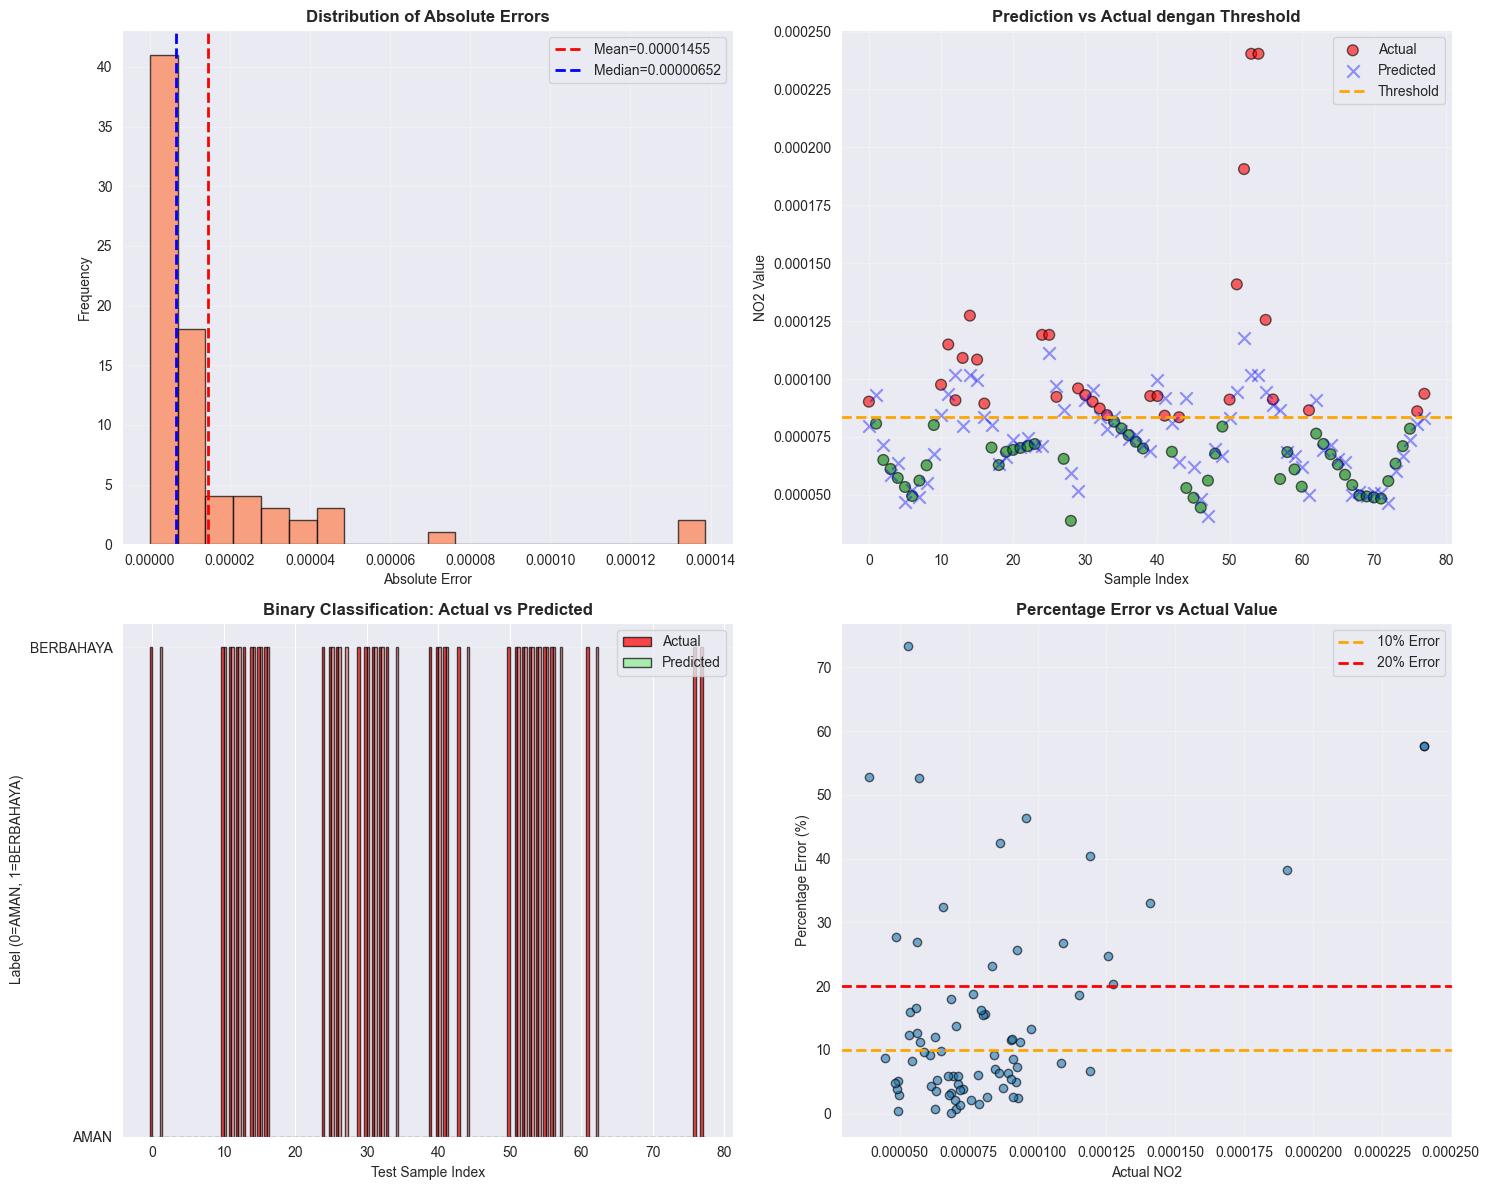

In [11]:
# Analisis Error Distribution
errors = np.abs(y_test - y_pred_regression)
mean_error = np.mean(errors)
median_error = np.median(errors)
max_error = np.max(errors)
min_error = np.min(errors)
mape_error = np.mean(np.abs((y_test - y_pred_regression) / y_test)) * 100

print(f"\nError Analysis:")
print(f"  - Mean Absolute Error:   {mean_error:.8f}")
print(f"  - Median Absolute Error: {median_error:.8f}")
print(f"  - Max Error:             {max_error:.8f}")
print(f"  - Min Error:             {min_error:.8f}")
print(f"  - MAPE:                  {mape_error:.4f}%")

# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Error Distribution
axes[0, 0].hist(errors, bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[0, 0].axvline(x=mean_error, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_error:.8f}')
axes[0, 0].axvline(x=median_error, color='blue', linestyle='--', linewidth=2, label=f'Median={median_error:.8f}')
axes[0, 0].set_xlabel('Absolute Error')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Absolute Errors', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Prediction vs Actual dengan kategori
colors_scatter = ['green' if val <= threshold else 'red' for val in y_test]
axes[0, 1].scatter(range(len(y_test)), y_test, alpha=0.6, label='Actual', c=colors_scatter, edgecolors='k', s=60)
axes[0, 1].scatter(range(len(y_pred_regression)), y_pred_regression, alpha=0.4, label='Predicted', marker='x', s=80, c='blue')
axes[0, 1].axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label='Threshold')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('NO2 Value')
axes[0, 1].set_title('Prediction vs Actual dengan Threshold', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Binary Classification Result
x_pos = np.arange(len(y_test_binary))
width = 0.35
colors_actual = ['green' if x == 0 else 'red' for x in y_test_binary]
colors_pred = ['lightgreen' if x == 0 else 'lightcoral' for x in y_pred_binary]

axes[1, 0].bar(x_pos - width/2, y_test_binary, width, label='Actual', color=colors_actual, alpha=0.7, edgecolor='black')
axes[1, 0].bar(x_pos + width/2, y_pred_binary, width, label='Predicted', color=colors_pred, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Test Sample Index')
axes[1, 0].set_ylabel('Label (0=AMAN, 1=BERBAHAYA)')
axes[1, 0].set_title('Binary Classification: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_yticklabels(['AMAN', 'BERBAHAYA'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Percentage Error
percentage_error = (errors / y_test) * 100
axes[1, 1].scatter(y_test, percentage_error, alpha=0.6, edgecolors='k')
axes[1, 1].axhline(y=10, color='orange', linestyle='--', linewidth=2, label='10% Error')
axes[1, 1].axhline(y=20, color='red', linestyle='--', linewidth=2, label='20% Error')
axes[1, 1].set_xlabel('Actual NO2')
axes[1, 1].set_ylabel('Percentage Error (%)')
axes[1, 1].set_title('Percentage Error vs Actual Value', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Prediksi Nilai NO2 Satu Hari Ke Depan  
**Tujuan:** Gunakan model untuk prediksi status NO₂ satu hari ke depan

**Proses:**  
- Ambil 3 hari terakhir dari data (NO2(t-3), NO2(t-2), NO2(t-1)).
- Normalisasi dengan scaler yang sudah di-fit.
- Prediksi nilai NO₂ menggunakan final model.
- Terapkan threshold untuk klasifikasi status.
- Analisis: persentase perbedaan dari threshold.
- Visualisasi prediksi dengan bar chart.

Data 2 hari terakhir (Original):
 - NO2(t-2): 0.00008610 mol/m²
 - NO2(t-1): 0.00009364 mol/m²

Data 2 hari terakhir (Normalized - MinMaxScaler):
 - NO2(t-2): 0.6141
 - NO2(t-1): 0.6833

HASIL PREDIKSI NO2 HARI BESOK (1 hari):
 - Predicted NO2: 0.00009230 mol/m²
 - Threshold: 0.00008347
 - Status: BERBAHAYA
 - Difference: 0.00000883
 - Percentage: +10.58% dari threshold

 PERINGATAN SEDANG: 10.6% di atas threshold
   → WASPADA kualitas udara!


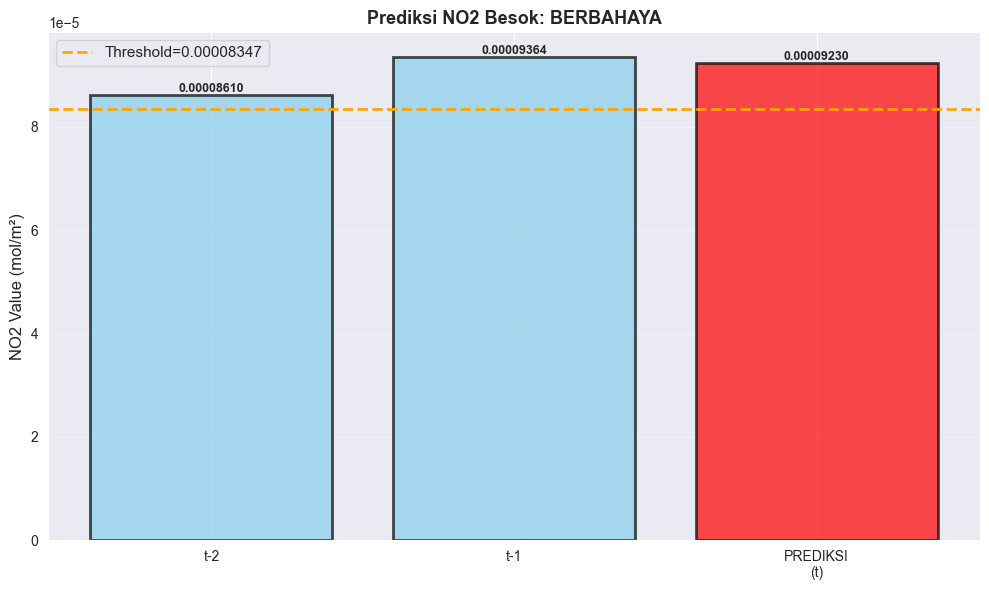

In [12]:
# Ambil last 2 days dari raw (bukan supervised_df)
last_2_raw = df["NO2"].values[-2:]   # shape (2,)

# Normalize input (pakai scaler yang sudah di-fit dari X_train)
last_2_scaled = scaler.transform(last_2_raw.reshape(1, -1))[0]  # shape (2,)

# Prediksi (model menerima scaled features; output = original scale)
pred_h1 = final_model.predict(last_2_scaled.reshape(1, -1))[0]

# Threshold dan interpretasi
diff = pred_h1 - threshold
pct = (diff / threshold) * 100
status = "BERBAHAYA" if pred_h1 > threshold else "AMAN"

# Tampilan hasil
print("Data 2 hari terakhir (Original):")
print(f" - NO2(t-2): {last_2_raw[0]:.8f} mol/m²")
print(f" - NO2(t-1): {last_2_raw[1]:.8f} mol/m²\n")

print("Data 2 hari terakhir (Normalized - MinMaxScaler):")
print(f" - NO2(t-2): {last_2_scaled[0]:.4f}")
print(f" - NO2(t-1): {last_2_scaled[1]:.4f}\n")

print("HASIL PREDIKSI NO2 HARI BESOK (1 hari):")
print(f" - Predicted NO2: {pred_h1:.8f} mol/m²")
print(f" - Threshold: {threshold:.8f}")
print(f" - Status: {status}")
print(f" - Difference: {diff:.8f}")
print(f" - Percentage: {pct:+.2f}% dari threshold")

# Interpretasi status
if status == 'BERBAHAYA':
    if pct > 20:
        print(f"\n PERINGATAN TINGGI: NO2 diprediksi {pct:.1f}% DI ATAS threshold!")
        print(f"   → Kondisi SANGAT BERBAHAYA!")
    elif pct > 10:
        print(f"\n PERINGATAN SEDANG: {pct:.1f}% di atas threshold")
        print(f"   → WASPADA kualitas udara!")
    else:
        print(f"\n PERINGATAN: {pct:.1f}% di atas threshold")
        print(f"   → Perlu monitoring!")
else:
    if abs(pct) < 5:
        print(f"\n HATI-HATI: hanya {abs(pct):.1f}% DI BAWAH threshold")
        print(f"   → Masih aman, tapi dekat ambang!")
    else:
        print(f"\n AMAN: {abs(pct):.1f}% di bawah threshold")
        print(f"   → Kualitas udara aman")

# Visualisasi
fig, ax = plt.subplots(figsize=(10, 6))

days = ['t-2', 't-1', 'PREDIKSI\n(t)']
values = list(last_2_raw) + [pred_h1]
colors_bar = ['skyblue', 'skyblue', 'red' if status == 'BERBAHAYA' else 'green']

bars = ax.bar(days, values, color=colors_bar, alpha=0.7,
              edgecolor='black', linewidth=2)

ax.axhline(y=threshold, color='orange', linestyle='--', linewidth=2,
           label=f'Threshold={threshold:.8f}')

ax.set_ylabel('NO2 Value (mol/m²)', fontsize=12)
ax.set_title(f'Prediksi NO2 Besok: {status}',
             fontsize=13, fontweight='bold')

ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Tambahkan label nilai
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.8f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## IMPLEMENTASI MODEL (Deployment)

### Load dan simpan model pada folder deploy

In [13]:
import os
import joblib
import numpy as np

# Load scaler & model
scaler = joblib.load('minmax_scaler.pkl')
model = joblib.load('knn_model.pkl')

print("Scaler & model berhasil diload.")

# Simpan ulang ke folder lain
save_dir = "../psd_deploy_NO2/models"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "knn_model.pkl")
scaler_path = os.path.join(save_dir, "minmax_scaler.pkl")

joblib.dump(model, model_path)
joblib.dump(scaler, scaler_path)

print(f"Model dan scaler berhasil disimpan di folder: {save_dir}")

Scaler & model berhasil diload.
Model dan scaler berhasil disimpan di folder: ../psd_deploy_NO2/models


### Membuat file `app.py` dengan code:  


```python
import streamlit as st
import numpy as np
import pandas as pd
import joblib
import os
import plotly.graph_objs as go
from datetime import datetime, timedelta

# CONFIG
MODEL_PATH = "models/knn_model.pkl"
SCALER_PATH = "models/minmax_scaler.pkl"
MAX_DAYS = 30

st.set_page_config(page_title="NO₂ Multi-step Forecast (KNN)", layout="wide")
st.title("Prediksi Kadar NO₂ — Multi-step Forecast (KNN + MinMaxScaler)")

# CEK MODEL DAN SCALER
if not os.path.exists(MODEL_PATH) or not os.path.exists(SCALER_PATH):
    st.error("File model atau scaler tidak ditemukan. Pastikan ada di folder `models/`:\n- knn_model.pkl\n- minmax_scaler.pkl")
    st.stop()

model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

data_min = scaler.data_min_
data_max = scaler.data_max_
data_range = data_max - data_min

# INPUT SECTION
st.markdown("### Pengaturan Prediksi")

days_to_predict = st.number_input("Berapa hari ke depan (H)?", min_value=1, max_value=MAX_DAYS, value=3, step=1)
threshold = 8.347e-05  # mol/m²
show_ugm3 = st.checkbox("Tampilkan juga hasil konversi ke µg/m³", value=True)

st.markdown(f"**Threshold Kadar NO₂:** {threshold:.8e} mol/m²")
st.markdown("---")

st.subheader("Input 2 Hari Terakhir (lag=2)")
st.info("Masukkan 2 nilai NO₂ (mol/m²) secara manual:")

col1, col2 = st.columns([2, 1])
with col1:
    input_t2 = st.number_input("NO₂(t-2) [mol/m²]", min_value=0.0, format="%.10f", value=0.00008951)
    input_t1 = st.number_input("NO₂(t-1) [mol/m²]", min_value=0.0, format="%.10f", value=0.00009666)
with col2:
    st.markdown("**Preview Input:**")
    st.metric("NO₂(t-2)", f"{input_t2:.8f}")
    st.metric("NO₂(t-1)", f"{input_t1:.8f}")

# HELPER FUNCTIONS
def normalize_pair(arr_orig):
    norm0 = (arr_orig[0] - data_min[0]) / (data_range[0] if data_range[0] != 0 else 1.0)
    norm1 = (arr_orig[1] - data_min[1]) / (data_range[1] if data_range[1] != 0 else 1.0)
    return np.array([norm0, norm1])

def normalize_value_col1(val):
    return (val - data_min[1]) / (data_range[1] if data_range[1] != 0 else 1.0)

def to_ugm3(mol_m2):
    return mol_m2 * 46010

def multi_step_recursive(last2_orig, n_steps, model, scaler):
    preds = []
    w_norm = normalize_pair(last2_orig)
    w_orig = np.array(last2_orig, dtype=float)
    for step in range(1, n_steps + 1):
        X_in = w_norm.reshape(1, -1)
        pred_orig = model.predict(X_in)[0]
        preds.append(float(pred_orig))
        norm_pred_col1 = normalize_value_col1(pred_orig)
        w_norm = np.array([w_norm[1], norm_pred_col1])
        w_orig = np.array([w_orig[1], pred_orig])
    return preds

# RUN PREDIKSI
run_btn = st.button("Jalankan Multi-step Forecast")
if run_btn:
    last2_raw = np.array([input_t2, input_t1], dtype=float)
    last2_norm = normalize_pair(last2_raw)
    preds = multi_step_recursive(last2_raw, int(days_to_predict), model, scaler)

    # OUTPUT DETAIL TEKS
    st.markdown("### **Detail Perhitungan Prediksi per Hari**")

    st.markdown(f"""
**Data 2 hari terakhir (Original):**
 - NO₂(t-2): {last2_raw[0]:.8f} mol/m²
 - NO₂(t-1): {last2_raw[1]:.8f} mol/m²

**Data 2 hari terakhir (Normalized - MinMaxScaler):**
 - NO₂(t-2): {last2_norm[0]:.4f}
 - NO₂(t-1): {last2_norm[1]:.4f}

**HASIL PREDIKSI NO₂ PER HARI:**
──────────────────────────────
""")

    for i, pred in enumerate(preds, start=1):
        diff = pred - threshold
        pct = (diff / threshold) * 100
        status = "BERBAHAYA" if pred > threshold else "AMAN"

        st.markdown(f"""
**Hari ke-{i}:**
 - Predicted NO₂: {pred:.8f} mol/m²
 - Threshold: {threshold:.8f}
 - Status: {status}
 - Difference: {diff:+.8f}
 - Percentage: {pct:+.2f}% dari threshold
""")

        # Tampilkan warning sesuai status
        if status == 'BERBAHAYA':
            if pct > 20:
                st.error(f"**PERINGATAN TINGGI:** NO₂ {pct:.1f}% di atas threshold → **SANGAT BERBAHAYA!**")
            elif pct > 10:
                st.warning(f"**PERINGATAN SEDANG:** {pct:.1f}% di atas threshold → **Waspada!**")
            else:
                st.error(f"**PERINGATAN:** {pct:.1f}% di atas threshold → **Perlu monitoring.**")
        else:
            if abs(pct) < 5:
                st.warning(f"**HATI-HATI:** hanya {abs(pct):.1f}% di bawah threshold → **Masih aman, tapi mendekati batas.**")
            else:
                st.success(f"**AMAN:** {abs(pct):.1f}% di bawah threshold → **Kualitas udara baik.**")

        st.markdown("---")

    # VISUALISASI
    base_date = datetime.utcnow()
    # Hari ini (t) = prediksi pertama
    past_dates = [
        (base_date - timedelta(days=2)).strftime("%Y-%m-%d"),
        (base_date - timedelta(days=1)).strftime("%Y-%m-%d"),
        base_date.strftime("%Y-%m-%d")  # hari ini!
    ]
    future_dates = [(base_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(1, len(preds))]
    full_dates = past_dates + future_dates

    # Nilai hari ini = preds[0]
    full_values = [input_t2, input_t1, preds[0]] + preds[1:]

    df_out = pd.DataFrame({
        "Tanggal": full_dates,
        "NO2(mol/m²)": full_values
    })
    if show_ugm3:
        df_out["NO2(µg/m³)"] = df_out["NO2(mol/m²)"].apply(to_ugm3)
    df_out["Status"] = np.where(df_out["NO2(mol/m²)"] > threshold, "BERBAHAYA", "AMAN")

    st.markdown("### Visualisasi Nilai NO₂ (2 Hari Sebelumnya + Prediksi)")
    colors = ["#2E86AB", "#2E86AB"] + ["red" if s == "BERBAHAYA" else "green" for s in df_out["Status"][2:]]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=df_out["Tanggal"],
        y=df_out["NO2(mol/m²)"],
        marker_color=colors,
        name="NO₂ (mol/m²)",
        hovertemplate="Tanggal: %{x}<br>NO₂: %{y:.8f}"
    ))
    fig.add_trace(go.Scatter(
        x=df_out["Tanggal"],
        y=[threshold]*len(df_out),
        mode="lines",
        name="Threshold",
        line=dict(dash="dash", color="orange"),
        hovertemplate="Threshold: %{y:.8f}"
    ))
    fig.update_layout(
        title="Kadar NO₂ per Hari",
        xaxis_title="Tanggal",
        yaxis_title="NO₂ (mol/m²)",
        template="plotly_white",
        height=500
    )
    st.plotly_chart(fig, use_container_width=True)

    # TABEL + DOWNLOAD
    st.markdown("### Data Lengkap")
    st.dataframe(df_out.style.format({
        "NO2(mol/m²)": "{:.8f}",
        "NO2(µg/m³)": "{:.4f}",
    }), use_container_width=True)

    csv_out = df_out.to_csv(index=False).encode('utf-8')
    st.download_button("Unduh hasil (CSV)", csv_out, "no2_multi_forecast.csv", "text/csv")
```

Link GitHub: https://github.com/AqbilBarakaa/psd_deploy

### Mempersiapkan lingkungan aplikasi

In [14]:
%pip install streamlit joblib numpy pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Menjalankan Aplikasi  

```streamlit run app.py```

### Hasil Deploy:  

https://tugaspsdtimeseries.streamlit.app/